In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [5]:
DATASET_ID = 'zebra_finch_gardner_segmented'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'zf.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/zebra_finch_gardner_segmented/zf.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

start_time  end_time  indv  indvi        key  \
0       0.000     0.143  lr12      0  lr12_2551   
1       0.149     0.227  lr12      0  lr12_2551   
2       0.239     0.343  lr12      0  lr12_2551   

                                               audio   rate  \
0  [-0.005017217410633742, -0.030003277431562933,...  48000   
1  [-0.017890375310140837, -0.017437939973938076,...  48000   
2  [0.013705346311330276, 0.013260862628047545, 0...  48000   

                                         spectrogram  
0  [[0.11670862, 0.06737542, 0.084003605, 0.12961...  
1  [[0.0, 0.0, 0.06625868, 0.10274482, 0.05996425...  
2  [[0.0, 0.27093738, 0.040522195, 0.114609785, 0...

In [10]:
len(syllable_df)

65893

Text(0.5, 1.0, 'min')

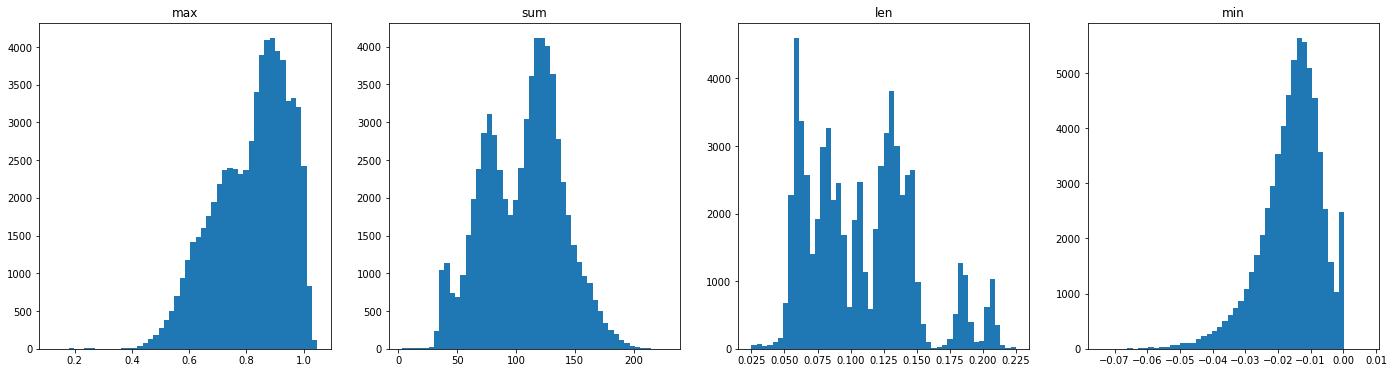

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [12]:
len(syllable_df)

65893

In [13]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [14]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(65893, 576)

(25.0, 10) (320, 800) 25.0 32 800


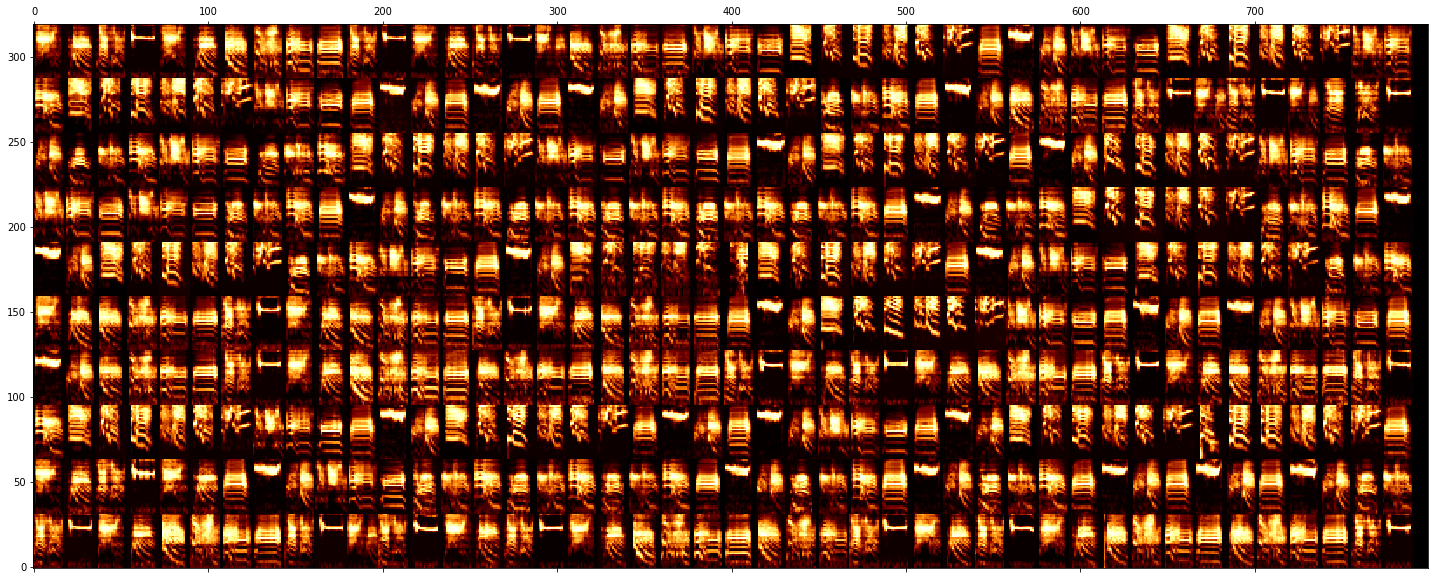

In [15]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

### variation across individuals

In [16]:
syllable_df.indv.unique()

array(['lr12', 'lr77', 'lr28', 'lr13', 'lny64', 'lny42'], dtype=object)

In [17]:
from avgn.visualization.quickplots import draw_projection_plots

lr12 11369
(25.0, 10) (320, 800) 25.0 32 800


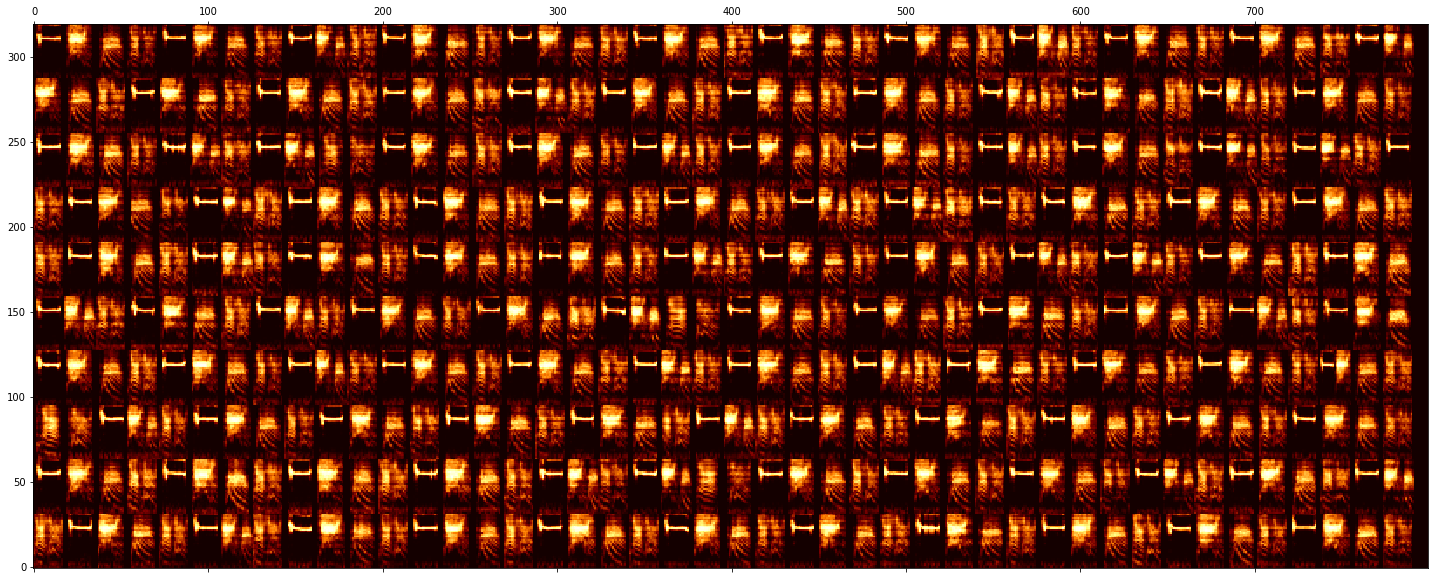

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


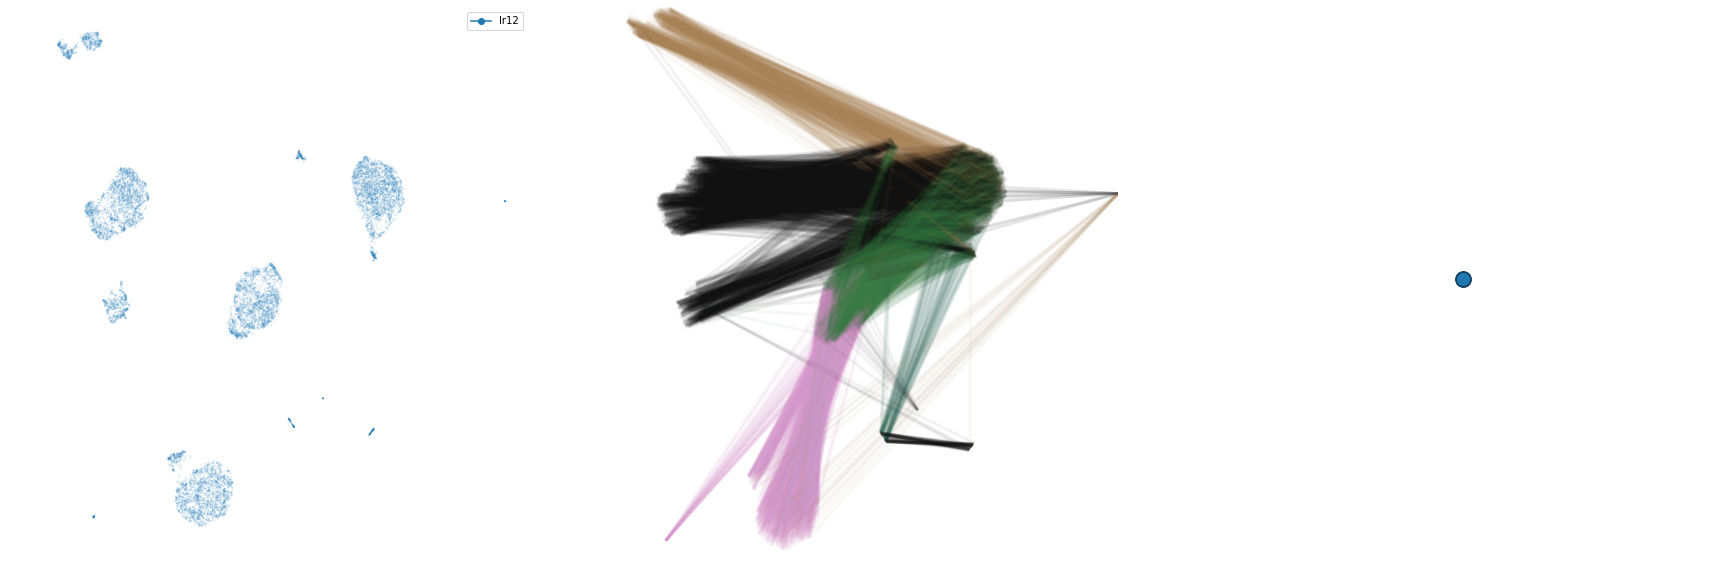

lr77 11931
(25.0, 10) (320, 800) 25.0 32 800


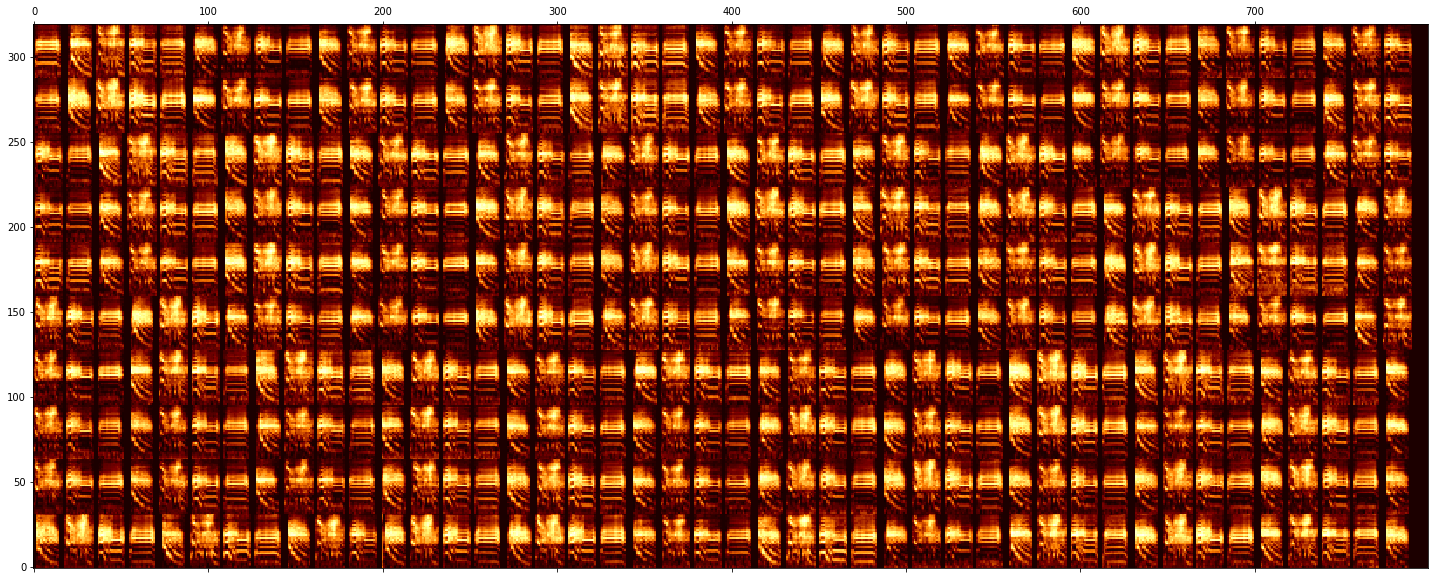

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


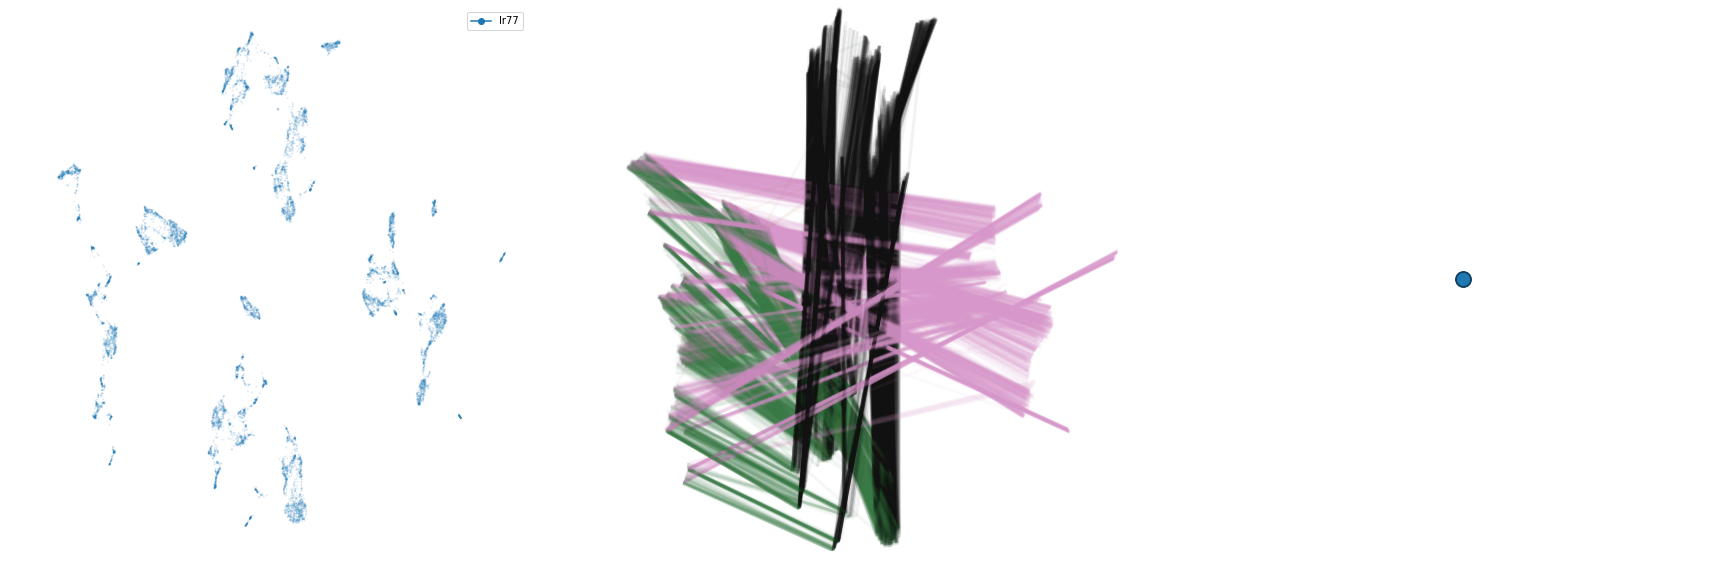

lr28 12067
(25.0, 10) (320, 800) 25.0 32 800


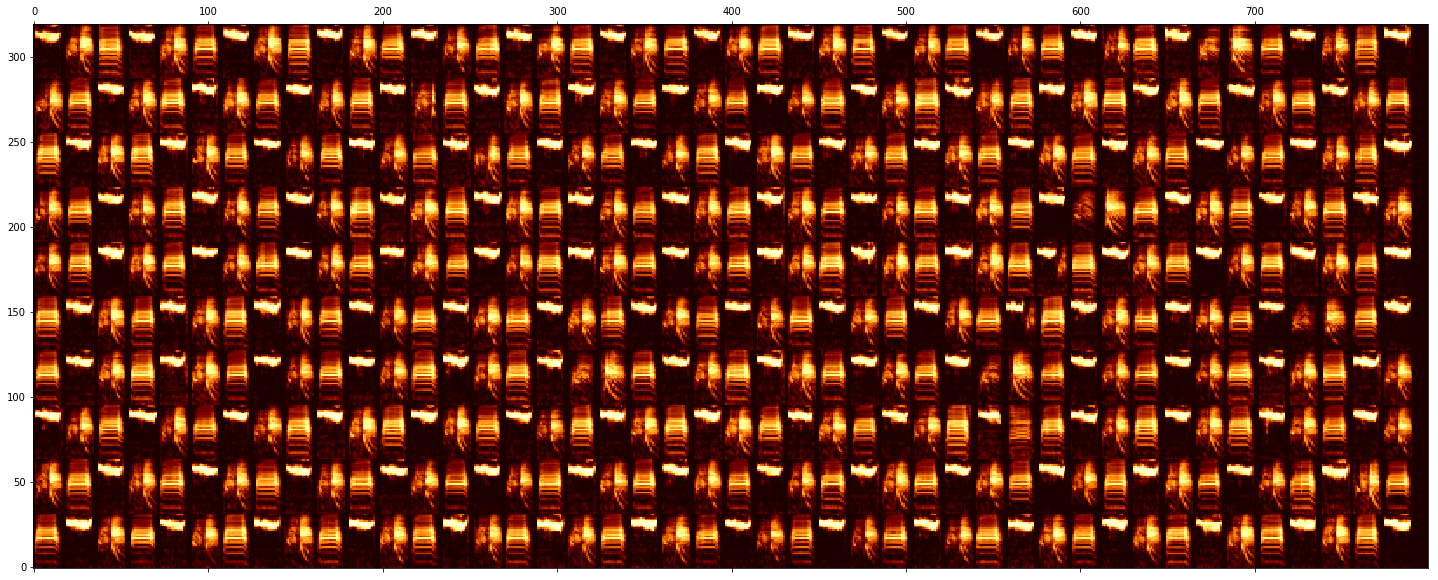

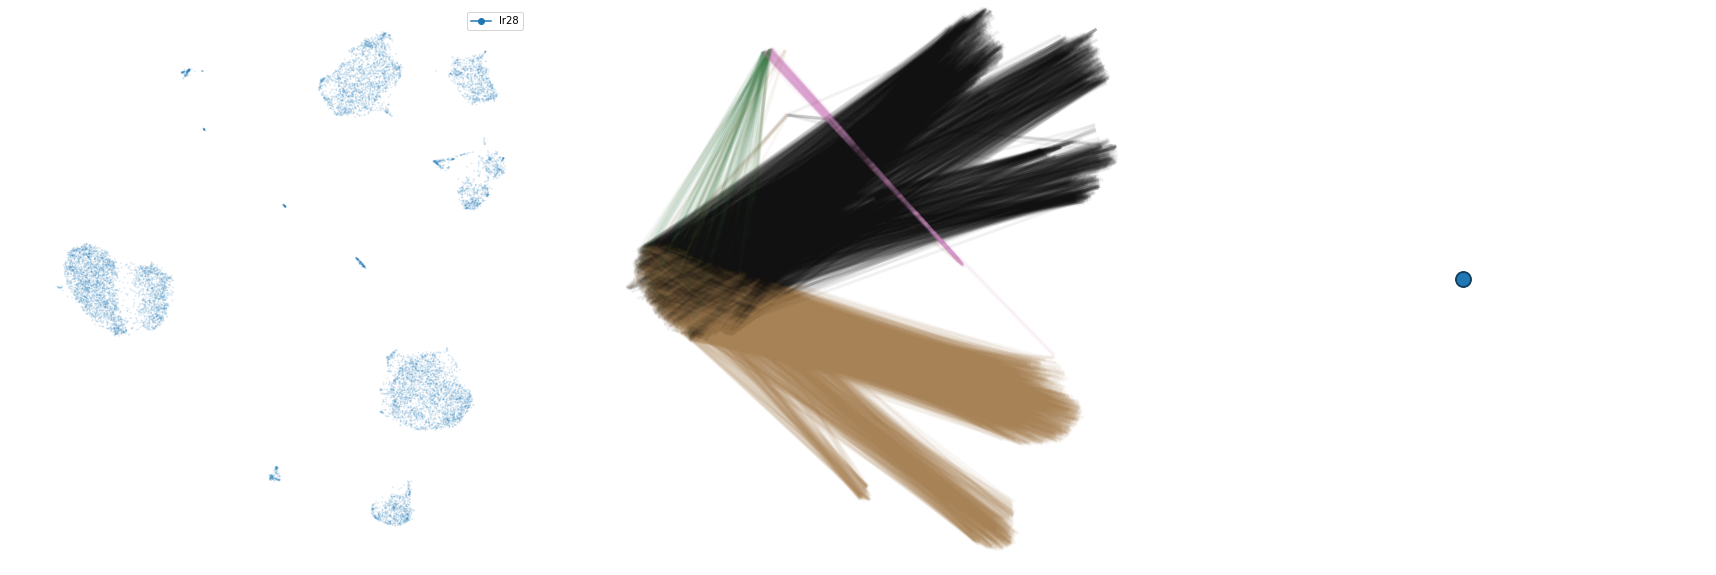

lr13 9118
(25.0, 10) (320, 800) 25.0 32 800


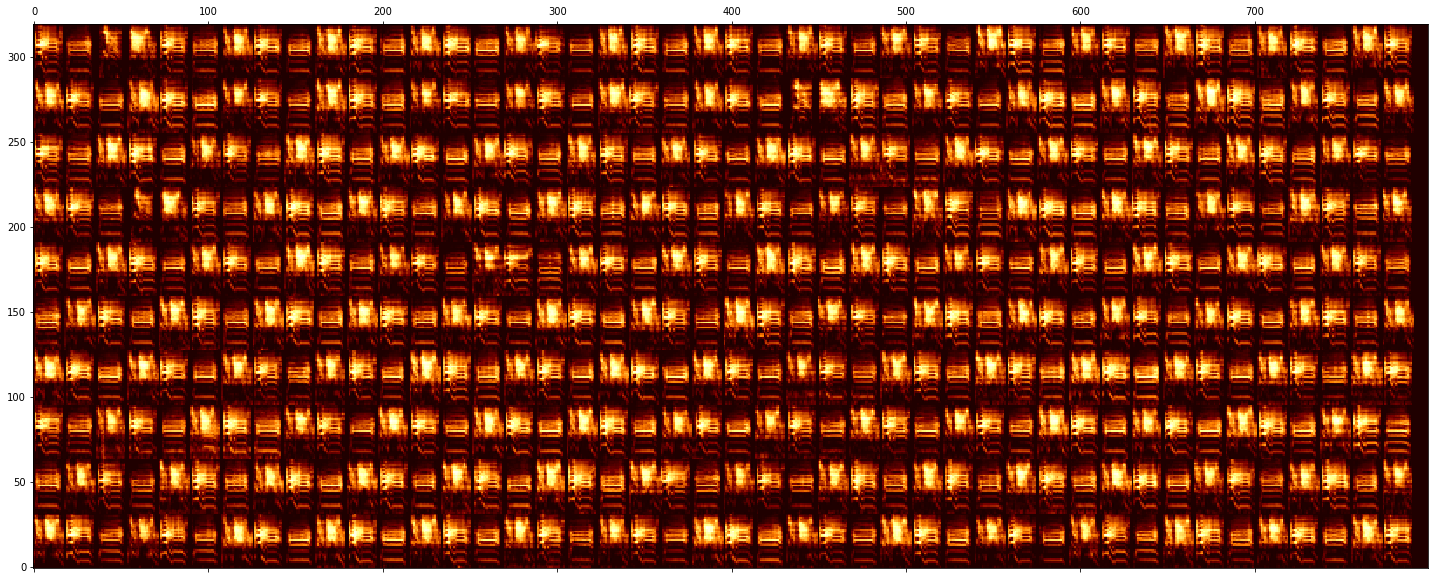

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


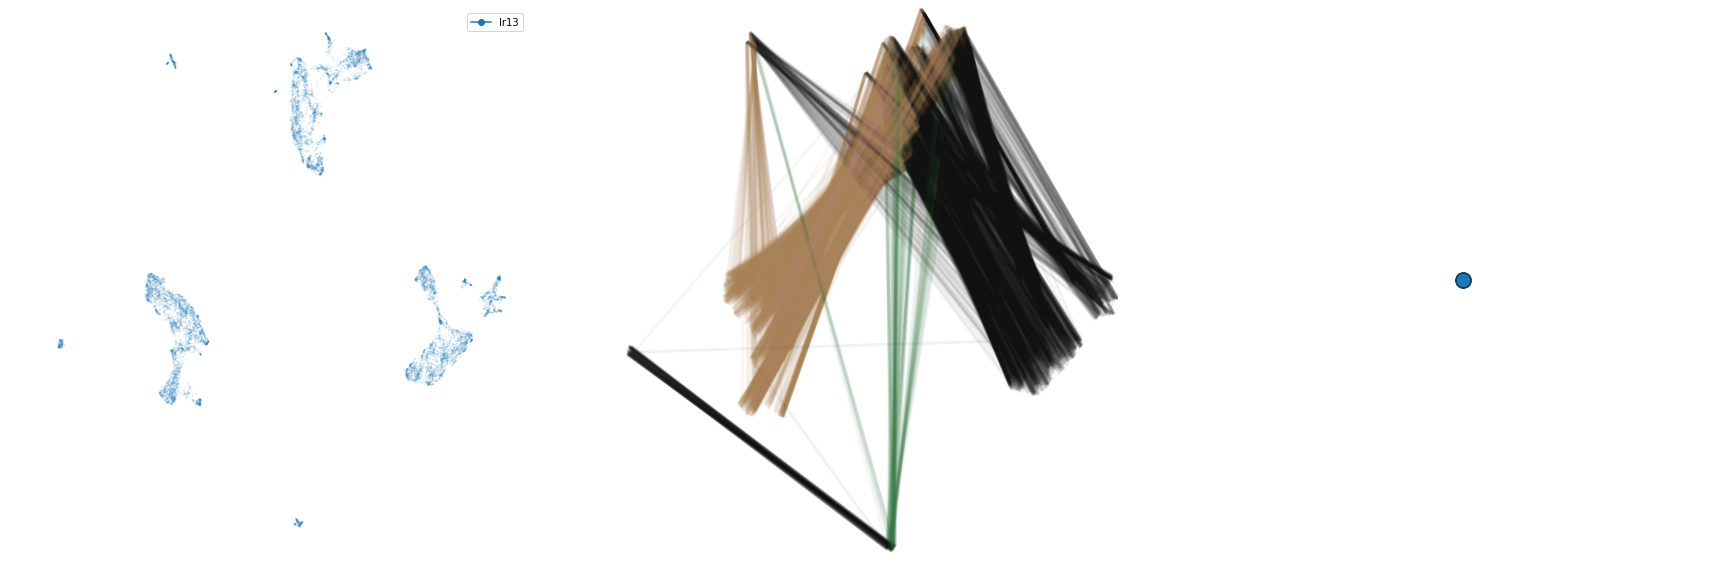

lny64 8449
(25.0, 10) (320, 800) 25.0 32 800


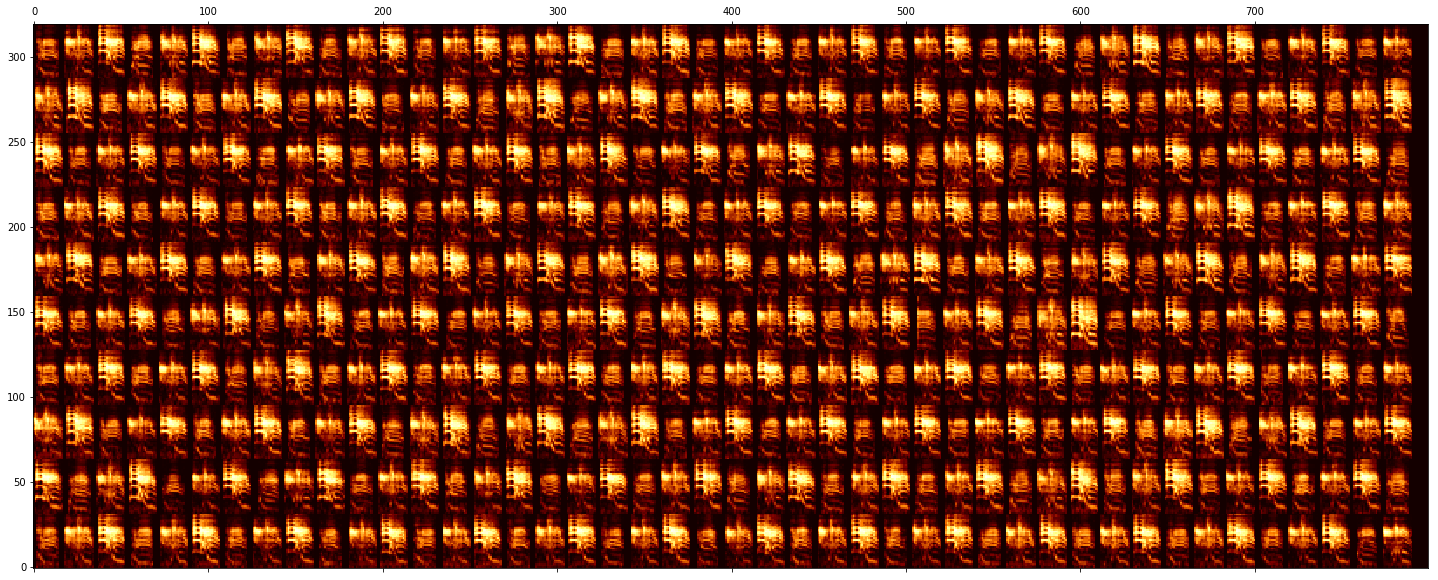

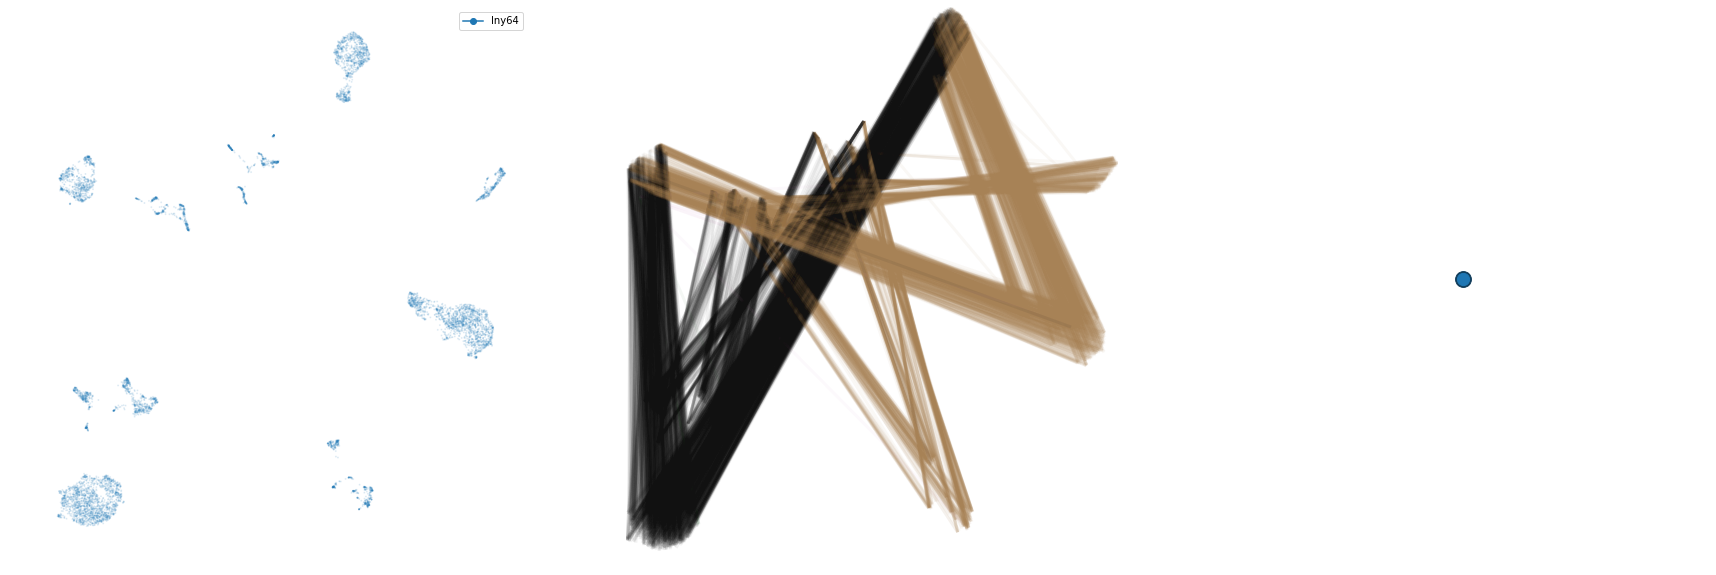

lny42 12959
(25.0, 10) (320, 800) 25.0 32 800


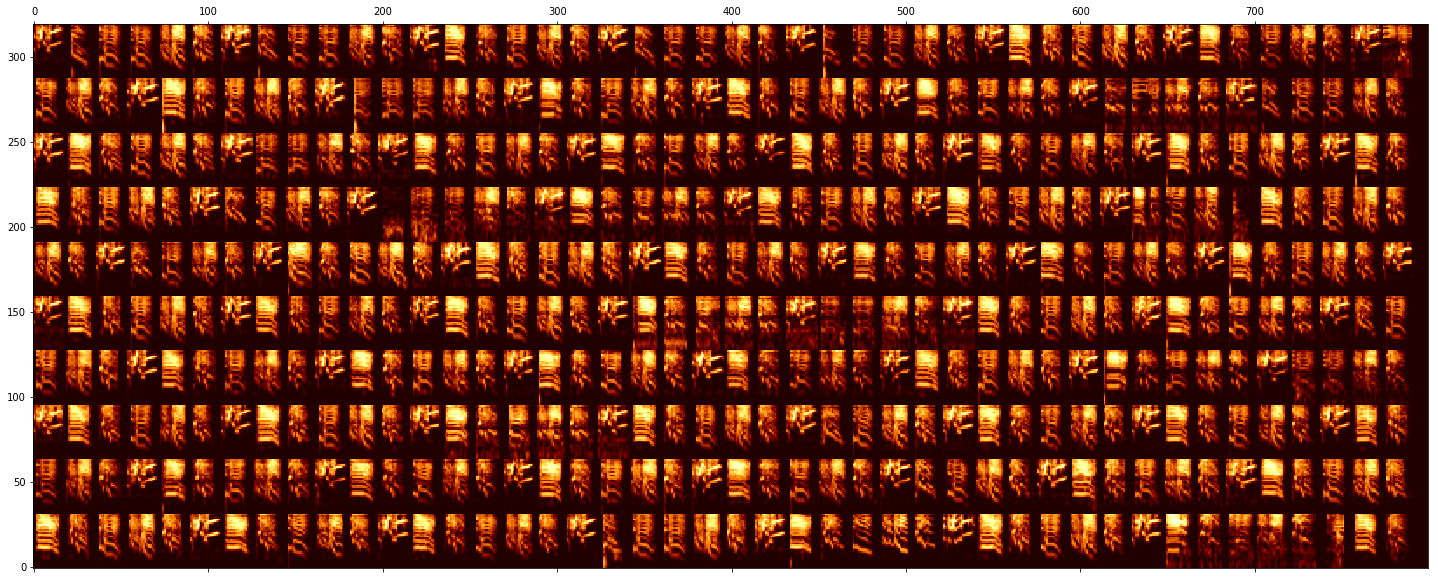

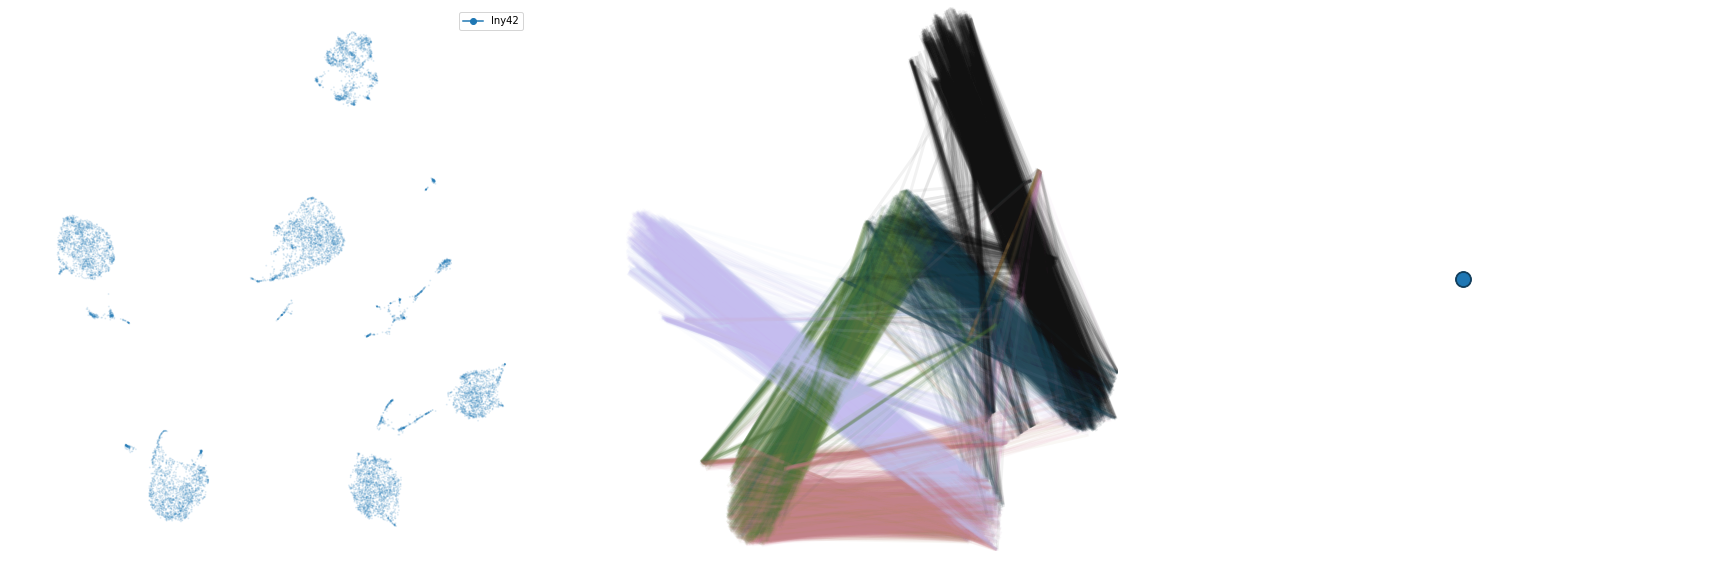

In [18]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    print(indv, len(indv_df))

    specs = list(indv_df.spectrogram.values)
    draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)
    
    specs_flattened = flatten_spectrograms(specs)

    fit = umap.UMAP()
    z = list(fit.fit_transform(specs_flattened))
    indv_df["umap"] = z

    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )

    draw_projection_plots(indv_df, label_column="indv")
    plt.show()